In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
value=cv2.imread("../input/happy-whale-and-dolphin/train_images/00021adfb725ed.jpg")
plt.imshow(value)

# Feature Extraction

# Color

# Find the mean color value in the image

$$\frac {\sum_{i=0}^{h} \sum_{n=0}^{w} img_{[i,n]}}{h*w*3}$$

In [ ]:
def mean(img):
    return np.mean(img)
mean(value)

# Cluster mean color among groups of 2 in image
we apply a kmeans cluster over the image to remove the water from the whale the majority class in the cluster propably belongs to the whale and then we compute the mean of each cluster we also count the number of values in the majority class

In [ ]:
flattened=cv2.resize(cv2.imread("../input/happy-whale-and-dolphin/train_images/0007d9bca26a99.jpg"),(128,128)).ravel()

In [ ]:
from sklearn.cluster import KMeans
model=KMeans(n_clusters=2).fit(flattened[...,np.newaxis])
model.labels_

In [ ]:
def compute_mean_over_clusters(image,plot=False):
    flattened=np.mean(image,axis=-1).ravel()
   
    model=KMeans(n_clusters=2).fit(flattened[...,np.newaxis])
    majority=int(np.mean(model.labels_)>=0.5)
 
    labels=model.labels_
    if majority==0:
        labels=1-labels
    labels=labels.reshape(image.shape[0],image.shape[1],1)
   
    if plot:
        plt.matshow(labels*image)
   
    return np.sum(image*labels)/(np.sum(labels)*3),np.sum(image*(1-labels))/(np.sum(1-labels)*3),np.sum(labels)

In [ ]:
compute_mean_over_clusters(cv2.resize(value,(128,128)),True)

# Skewness 
skewness of an image can be defined as the symetrical values of the image u can see it here for more detail https://stats.stackexchange.com/questions/211377/skewness-and-kurtosis-in-an-image. Anyways when we replicate it into a image we first take each channel of the image flatten it compute the histogram and finally the skewness using this formula $$\frac {\sum_{i}^{N} (X_i - X_{hat}) ^ 3}{(N-1) * σ^3}$$

which many people might know about here is unscarry look of the same formula Skew = 3 * (Mean – Median) / Standard Deviation . Anyways doing it for all 3 channels and taking an mean is what i am doing here

In [ ]:
from scipy.stats import skew
def skewness(image):
    return (skew(image[...,0].flatten())+skew(image[...,1].flatten())+skew(image[...,2].flatten()))/3
skewness(value)

# Kurtosis
 Statistically speaking it just mean "tailedness" of a histogram or a distribution like this . A  positive value means lot of data in the tail of the distribution while negative is less data on the tails 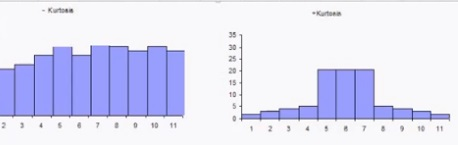 from : https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/kurtosis-leptokurtic-platykurtic/ . 

In [ ]:
from scipy.stats import kurtosis
def kurtosisness(image):
    return (kurtosis(image[...,0].flatten())+kurtosis(image[...,1].flatten())+kurtosis(image[...,2].flatten()))/3
kurtosisness(value)

# Median of the image

In [ ]:
np.median(value)

# One Function to Wrap it all

In [ ]:
def compute_feats(image):
    image=cv2.resize(image,(128,128))
    M=mean(image)
    m1,m2,G=compute_mean_over_clusters(image)
    S=skewness(image)
    K=kurtosisness(image)
    return np.array([M,m1,m2,G,S,K])

In [ ]:
compute_feats(value)

# Exporting the Features into a .csv file

In [ ]:
import pandas as pd
from glob import glob
from tqdm import tqdm
import concurrent
import sys
path='../input/happy-whale-and-dolphin/train_images/*.jpg'
pbar=tqdm(total=len(glob(path)))
def process(image):
    
    m=compute_feats(cv2.imread(image))
    pbar.update(1)
    return m


with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    images=list(executor.map(process,glob(path)))
    
    

In [ ]:
images=np.array(images)

In [ ]:
df=pd.DataFrame()
df['mean']=images[...,0]
df['mean1']=images[...,1]
df['mean2']=images[...,2]
df['segment_size']=images[...,3]
df['skewness']=images[...,4]
df['kurtosis']=images[...,5]
df['filename']=glob(path)

In [ ]:
df.head()

In [ ]:
df.to_csv('feats.csv',index=False)